In [ ]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.hotspells import *

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
exp_s = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_s_low = Experiment(
    "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)
exp_T = Experiment(
    "ERA5", "t", "6H", "all", "JJA", -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 24 * 10)}, None,
)
da_T = exp_T.da

In [ ]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_ds['exists'] = (~props_as_ds['mean_lon'].isnull()).astype(np.float32)

In [ ]:
net, centers, labels = exp_s.compute_som(
    6,
    6,
    200,
    return_type=ADJUST_REALSPACE,
    train_kwargs=dict(train_algo="batch", epochs=1000),
)

n_samples = net.compute_populations()
coords = net.neighborhoods.coordinates
mask = labels_to_mask(labels)
mask_none = mask[:, 0]
mask = mask[:, 1:]
center_none = centers[0]
centers = centers[1:]
centers_all_jets = find_all_jets(centers, height=25, cutoff_blobs=750, cutoff_jets=1200, chunksize=3)
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds = props_to_ds(centers_props, centers.cluster)

bmus_da = xr.DataArray(net.bmus, coords={'time': da_s.time.values})
labels_daily = bmus_da.interp(coords={'time': da_T.time.values}, method='nearest').astype(int).values
mask_daily = labels_to_mask(labels_daily)
populations = (centers.ratios.values * len(da_s.time)).astype(int)

2023-12-05 15:40:27.970 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2023-12-05 15:40:27.976 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2023-12-05 15:40:28.044 | INFO     | simpsom.network:_set_weights:223 - The weights will be loaded from file
100%|██████████| 36/36 [00:00<00:00, 425.98it/s]


## On a yearly basis

In [ ]:
def get_frequency_anomaly(hs_mask, year: int | Sequence = YEARSPL_EXT, lag_behind: int = 1): 
    if isinstance(year, int):
        year = [year]
    mask_thisyear = labels.time.dt.year.isin(year)
    unique_labels, counts = np.unique(labels.sel(time=mask_thisyear), return_counts=True)
    thisyear_pops = np.zeros(net.n_nodes, dtype=int)
    thisyear_pops[unique_labels[1:] - 1] = counts[1:]
    thisyear_probas = thisyear_pops / np.sum(thisyear_pops)
    hs_mask = hs_mask.sel(time=mask_thisyear)
    len_thresh = 5
    conditional_probas = (
        np.sum(
            (hs_mask > len_thresh).values[:, :, -lag_behind, None] & mask[mask_thisyear.values, None, :], axis=0
        )
        / np.sum((hs_mask > len_thresh).values, axis=0)[:, -lag_behind, None]
    )
    return conditional_probas - thisyear_probas[None, :]

/scratch/local/742643/ipykernel_77519/184246462.py:10: RuntimeWarning: invalid value encountered in divide
  np.sum(
/scratch/local/742643/ipykernel_77519/184246462.py:10: RuntimeWarning: invalid value encountered in divide
  np.sum(


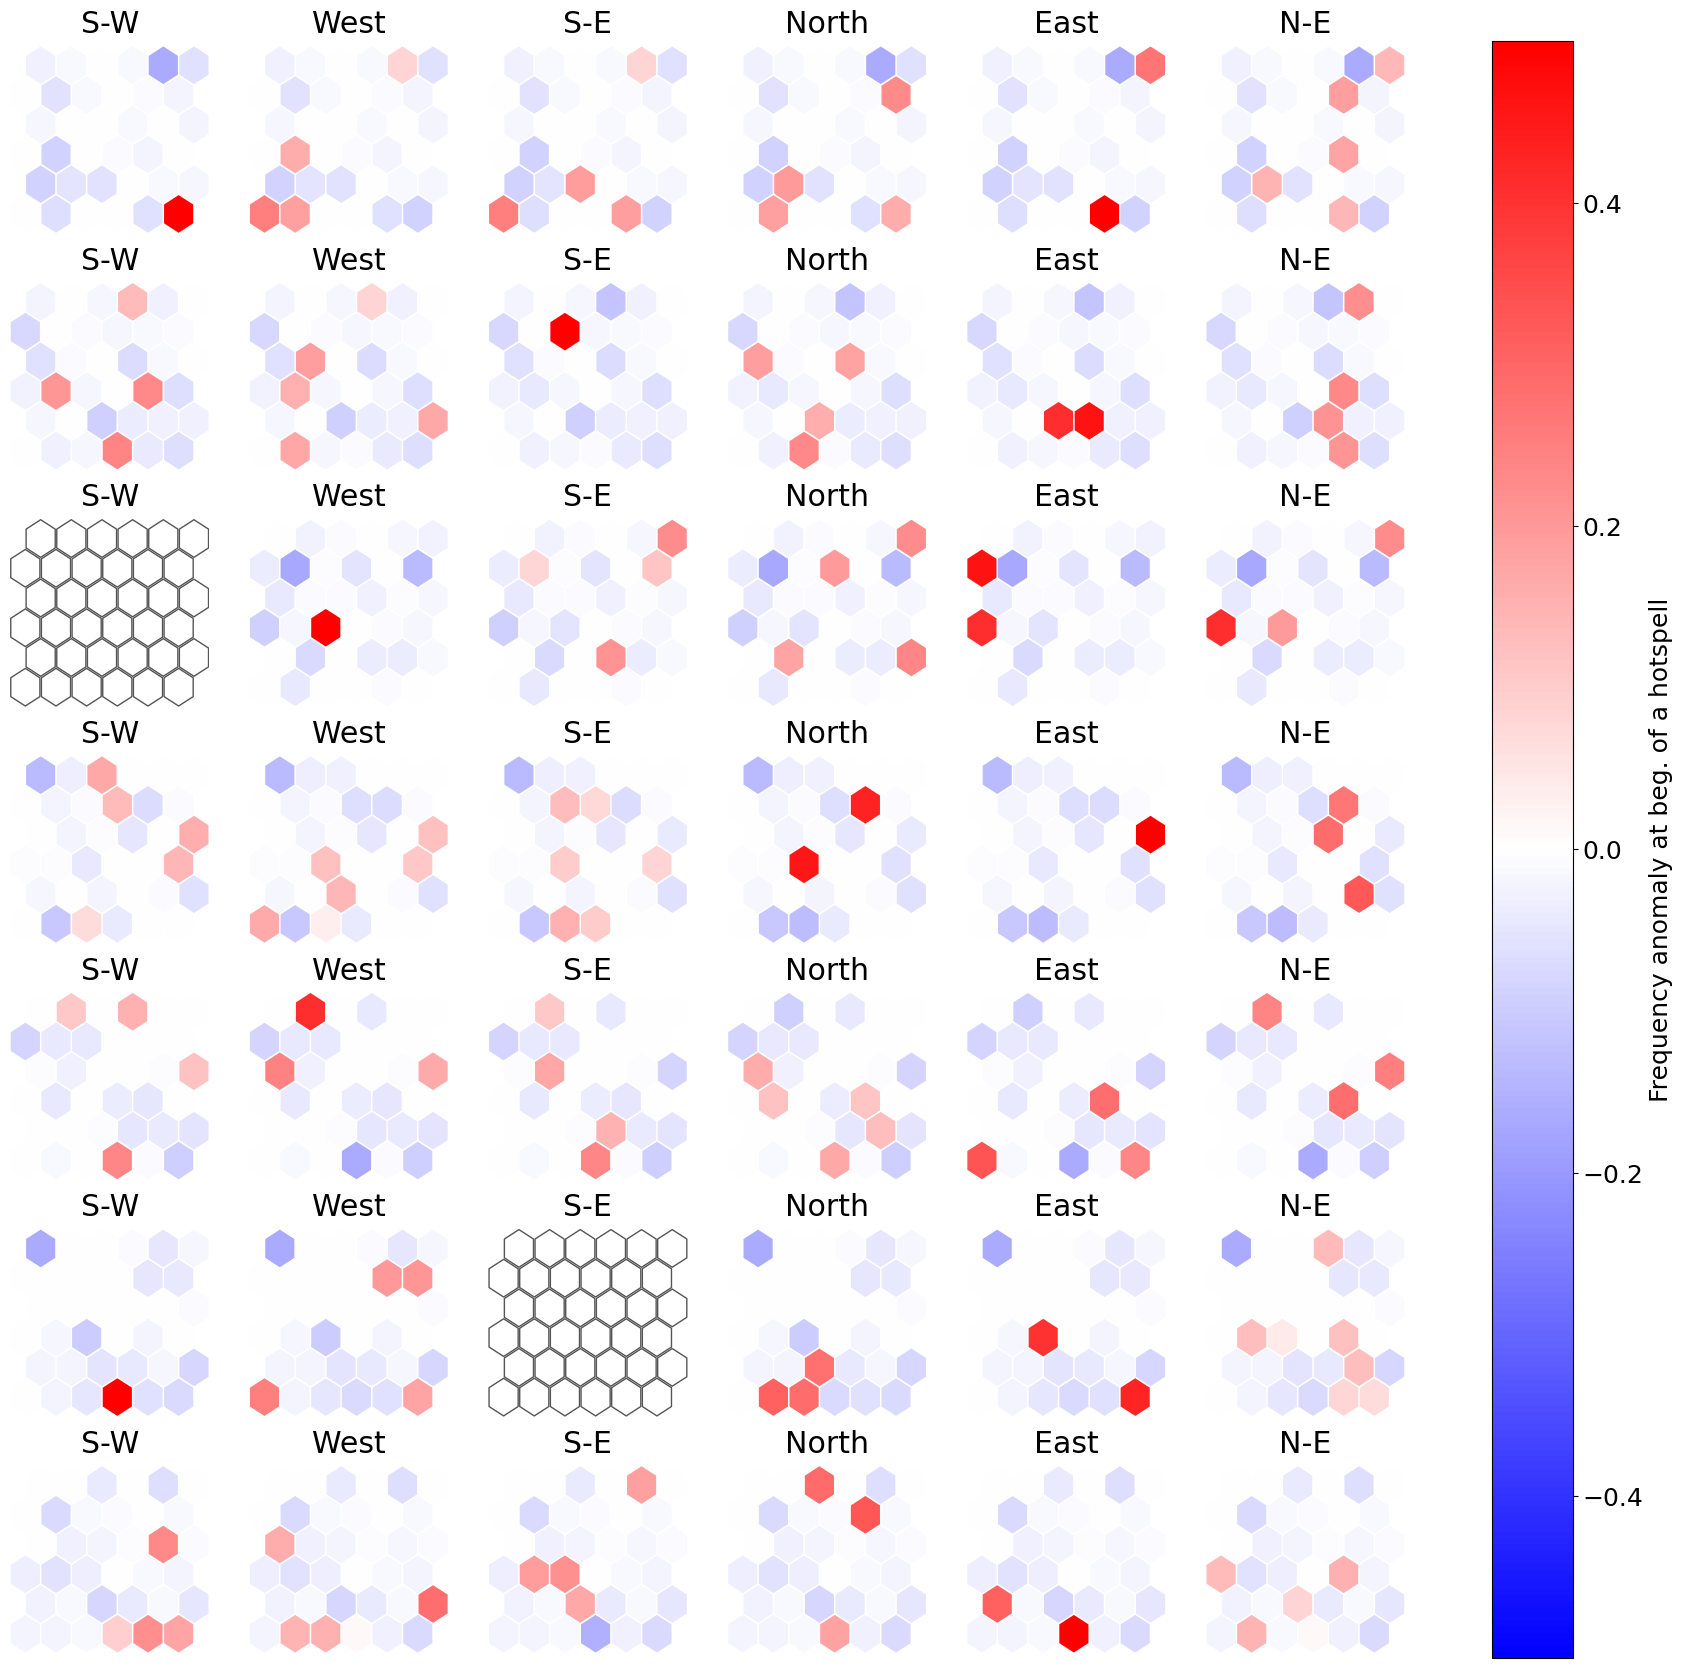

In [ ]:
lag_behind = 1
kwargs = {
    "cmap": "bwr",
    "norm": Normalize(-.5, .5),
}
years = [1983, 1990, 1997, 2003, 2010, 2018, 2022]
fig, axes = plt.subplots(len(years), 6, figsize=(3 * len(REGIONS) / 0.8, 3 * len(years)))
for iy, year in enumerate(years):
    to_plot = get_frequency_anomaly(hs_mask, year, lag_behind=1)

    for region, tplt, ax in zip(REGIONS, to_plot, axes[iy, :]):
        fig, ax = net.plot_on_map(
            tplt,
            smooth_sigma=0,
            show=False,
            fig=fig,
            ax=ax,
            draw_cbar=False,
            **kwargs
        )
        ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label="Frequency anomaly at beg. of a hotspell")

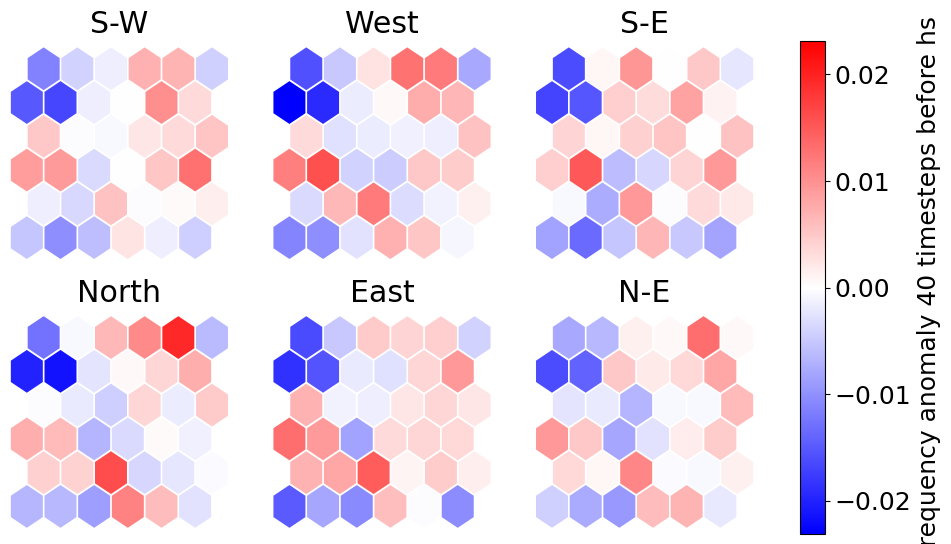

In [ ]:
to_plot = []
for lag_behind in range(41):
    to_plot.append(get_frequency_anomaly(hs_mask, lag_behind=lag_behind))
to_plot = np.mean(to_plot, axis=0)
kwargs = {
    "cmap": 'bwr',
    "norm": Normalize(- np.amax(np.abs(to_plot)), np.amax(np.abs(to_plot)))
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for k, (region, tplt) in enumerate(zip(REGIONS, to_plot)):
    ax = axes[k]
    fig, ax = net.plot_on_map(
        tplt,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        **kwargs,
    )
    ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label=f"Frequency anomaly {lag_behind} timesteps before hs")

## Events basis

In [ ]:
from simpsom import plots as splots
from simpsom.neighborhoods import Neighborhoods
from matplotlib.collections import LineCollection, PatchCollection
from matplotlib.patches import FancyArrowPatch


def get_traj(hotspell, bmus, timesteps_before = 0, timesteps_after = 0):
    last_time = hotspell[-1] + pd.Timedelta(18, 'h') + pd.Timedelta(6 * timesteps_after, 'h')
    times_before = da_s.time[da_s.time.dt.year==hotspell[-1].year].loc[:last_time][- timesteps_after - timesteps_before - 4 * len(hotspell):]
    bmus_da = xr.DataArray(bmus, coords={'time': da_s.time.values})
    traj_da = bmus_da.sel(time=times_before)
    return traj_da, traj_da.values


def get_region_mask(region: int):
    try: 
        duncan_mask
    except NameError:
        duncan_mask = np.abs(xr.open_dataarray(f"{DATADIR}/ERA5/cluster_def.nc"))
    return duncan_mask.interp(lat=np.arange(32, 72.25, 0.5)) == region + 1


def plt_traj_hotspell(hotspell, bmus, timesteps_before, timesteps_after, da_T, region_mask):
    coords = net.neighborhoods.coordinates.copy()
    traj_da, traj = get_traj(hotspell, bmus, timesteps_before, timesteps_after)
    nei = Neighborhoods(np, 10, 10, "hexagons", PBC=False)
    othernei = Neighborhoods(np, 6, 6, "hexagons", PBC=True)
    coords = nei.coordinates
    indices = np.arange(len(coords))
    outermask = (
        (indices // nei.height < 2)
        | (indices // nei.height > nei.height - 3)
        | (indices % nei.width < 2)
        | (indices % nei.width > nei.width - 3)
    )
    grid1 = np.arange(nei.width * nei.height).reshape(nei.height, nei.width, order="F")
    grid2 = np.arange(othernei.width * othernei.height).reshape(
        othernei.height, othernei.width, order="F"
    )
    theslice = slice(grid2.shape[0] - 2, grid2.shape[0] - 2 + grid1.shape[0])
    grid1[:, :2] = np.tile(grid2[:, -2:].T, 3)[:, theslice].T
    grid1[:, -2:] = np.tile(grid2[:, :2].T, 3)[:, theslice].T
    grid1[:2, :] = np.tile(grid2[-2:, :], 3)[:, theslice]
    grid1[-2:, :] = np.tile(grid2[:2, :], 3)[:, theslice]
    grid1 = grid1.flatten(order="F")
    grid1[~outermask] = grid2.flatten(order="F")
    edgecolors = np.full(len(coords), "black", dtype=object)
    edgecolors[outermask] = "gray"
    alphas = np.ones(len(coords))
    alphas[outermask] = 0.2

    populations = np.zeros_like(grid1)
    populations[outermask] = 0
    thesepops = np.sum(traj[:, None] == np.arange(net.n_nodes)[None, :], axis=0)
    populations[~outermask] = thesepops
    
    n1 = timesteps_before
    n2 = 4 * (len(hotspell) + 1)
    n3 = timesteps_after
    cmap2 = colormaps.cet_l_bmw1_r
    cmap1 = LinearSegmentedColormap.from_list('hoho', np.vstack((np.ones((1, 4)), cmap2(0.05))), 256)
    cmap3 = LinearSegmentedColormap.from_list('haha', np.vstack((cmap2(cmap2.N), np.ones((1, 4)))), 256)
    colors1 = cmap1(np.linspace(0.1, 1.0, n1 * 4))
    colors2 = cmap2(np.linspace(0.1, 1.0, n2 * 4))
    colors3 = cmap3(np.linspace(0.1, 1.0, n3 * 4))
    colors_stack = np.vstack((colors1, colors2, colors3))
    mymap = LinearSegmentedColormap.from_list('my_colormap', colors_stack)
    
    traj_split = np.split(traj, np.where((np.diff(traj) != 0))[0] + 1)
    sizes = np.asarray([len(stay) for stay in traj_split])
    uniques = np.asarray([stay[0] for stay in traj_split])
    color_array = np.asarray([0, *np.cumsum(sizes)], dtype=int)
    colors = mymap(np.linspace(0, 1, len(traj) + 1))[color_array]
    sort_like = np.argsort(sizes)[::-1]

    segments = []
    reps = []
    prev = coords[~outermask][traj_split[0][-1]]
    for k, j_ in enumerate(traj_split[1:]):
        j = j_[0]
        ks = np.where(grid1 == j)[0]
        distances = np.linalg.norm(prev[None, :] - coords[ks, :], axis=1)
        mindist = np.amin(distances)
        winnerks = ks[np.where(np.isclose(distances, mindist))[0]]
        next_ = coords[~outermask][j].copy()
        if np.all(outermask[winnerks]):
            winnerk = winnerks[0]
            segments.append(np.vstack([prev, coords[winnerk]]))
            ks = np.where(grid1 == traj_split[k][0])[0]
            distances = np.linalg.norm(next_[None, :] - coords[ks, :], axis=1)
            mindist = np.amin(distances)
            winnerk2 = ks[np.where(np.isclose(distances, mindist) & outermask[ks])[0][0]]
            segments.append(np.vstack([coords[winnerk2], next_]))
            reps.append(2)
        else:
            segments.append(np.vstack([prev, next_]))
            reps.append(1)
        prev = next_.copy()
        
    segments = np.asarray(segments)
    midpoints = 0.5 * (segments[:, 0, :] + segments[:, 1, :])
    tangents  = 0.5 * (segments[:, 1, :] - segments[:, 0, :])
    norm_tangents = np.linalg.norm(tangents, axis=-1)
    r = norm_tangents * 5
    tangents_perp = tangents[:, [1, 0]] * np.asarray([[1, -1]])
    centers = midpoints - np.sqrt(r[:, None] ** 2 / norm_tangents[:, None] ** 2 - 1) * tangents_perp
    correction = segments[:, :, 0] - centers[:, None, 0] < 0
    correction = np.pi * correction.astype(float)
    endpoints1 = np.arctan((segments[:, :, 1] - centers[:, None, 1]) / (segments[:, :, 0] - centers[:, None, 0])) - correction
    endpoints2 = np.arctan((segments[:, :, 1] - centers[:, None, 1]) / (segments[:, :, 0] - centers[:, None, 0])) + correction

    d1 = np.abs(endpoints1[:, 1] - endpoints1[:, 0])
    d2 = np.abs(endpoints2[:, 1] - endpoints2[:, 0])
    endpoints = np.where((d1 < d2)[:, None], endpoints1, endpoints2)    
    ts = (endpoints[:, 0, None] + (endpoints[:, 1, None] - endpoints[:, 0, None]) * np.linspace(0, 1, 50)[None, :])
    arcs = centers[:, None, :] + np.asarray([r[:, None] * np.cos(ts), r[:, None] * np.sin(ts)]).transpose(1, 2, 0)
    
    x1_arrow, y1_arrow = arcs[:, 22, :].T
    x2_arrow, y2_arrow = arcs[:, 27, :].T
    dx_arrow = x2_arrow - x1_arrow
    dy_arrow = y2_arrow - y1_arrow
    ds_arrow = np.sqrt(dx_arrow ** 2 + dy_arrow ** 2)
    dx_arrow = dx_arrow / ds_arrow * 0.15
    dy_arrow = dy_arrow / ds_arrow * 0.15
    arrows = []
    for x1, y1, dx, dy in zip(x1_arrow, y1_arrow, dx_arrow, dy_arrow):
        arrows.append(FancyArrowPatch(
            [x1, y1], [x1 + dx, y1 + dy], arrowstyle='wedge,tail_width=0.1,shrink_factor=0.4' 
        ))

    gs = plt.GridSpec(1, 4, width_ratios=[1, 0.05, 0.15, 0.05], wspace=0.01, left=0.01, right=0.9, bottom=0.01, top=0.99)
    fig = plt.figure(figsize=(6 * (1 + 0.4), 6))
    ax = fig.add_subplot(gs[0])
    ax_cbar = fig.add_subplot(gs[3])
    ax_temp = fig.add_subplot(gs[2], sharey=ax_cbar)
    
    kwargs = dict(
        cmap=mpl.colormaps["gray_r"], norm=Normalize(np.amin(thesepops), np.amax(thesepops))
    )
    xlims = [
        np.amin(coords[~outermask][:, 0]) - 0.8,
        np.amax(coords[~outermask][:, 0]) + 0.8,
    ]
    ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
    fig, ax = splots.plot_map(
        coords,
        populations,
        "hexagons",
        draw_cbar=False,
        figsize=(15, 13.5),
        show=False,
        edgecolors="black",
        cmap="Greys",
        alphas=alphas,
        linewidths=.5,
        fig=fig,
        ax=ax,
    )
    
    lc = LineCollection(arcs, colors=np.repeat(colors[1:-1], reps, axis=0), zorder=3)
    lc.set_linewidth(7)
    lc = ax.add_collection(lc)
    arrows = PatchCollection(arrows, zorder=9, edgecolor=None, facecolor='white')
    ax.add_collection(arrows)
    im = ScalarMappable(Normalize(0, len(traj) - 1), mymap)
    cbar = fig.colorbar(im, cax=ax_cbar, label=f"Time during the hotspell in {traj_da[0].time.dt.year.item()}")
    uniques = uniques[sort_like]
    sizes = sizes[sort_like]
    colors = colors[:-1][sort_like]
    ax.scatter(*coords[~outermask][uniques].T, s=100 * sizes, c=colors, zorder=10)
    
    every = (4 * (len(traj) // 40 + 1))
    list_of_days = np.asarray(np.arange(0, len(traj), every))
    pretty_list_of_days = traj_da[::every].time.dt.strftime("%b %d").values
    ax_cbar.set_yticks(list_of_days, labels=pretty_list_of_days)
    ax_cbar.invert_yaxis()
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    temperature_profile = da_T.loc[traj_da.time].where(region_mask).mean(dim=['lon', 'lat']).resample(time='1D').mean()
    # temperature_profile = (temperature_profile - temperature_profile.min()) / (temperature_profile.max() - temperature_profile.min())
    y = np.linspace(0, ax_cbar.get_ylim()[0], len(temperature_profile))
    ax_temp.spines[['top', 'left']].set_visible(False)
    ax_temp.set_ylabel('Regional temperature anomaly [K]')
    ax_temp.plot(temperature_profile, y, color='k', lw=2)
    ax_temp.fill_betweenx(y, temperature_profile, 0, temperature_profile <= 0, color='blue', alpha=0.6, interpolate=True)
    ax_temp.fill_betweenx(y, temperature_profile, 0, temperature_profile >= 0, color='red', alpha=0.6, interpolate=True)
    ax_temp.set_xticks([-3, 0, 3])
    ax_temp.tick_params(axis='y', labelleft=False, left=False, right=True, labelright=False, length=4, direction='in')
    ax_temp.invert_xaxis()
    ax_temp.grid(axis='x')
    
    if any(np.isin(traj, [29, 35, 28, 34])):
        left = 0.05
    else:
        left = 0.5
    cax = fig.add_axes([left, 0.009, 0.2, 0.05])
    im = ScalarMappable(**kwargs)
    fig.colorbar(im, cax=cax, orientation="horizontal")
    cax.set_xticks([0, np.amax(thesepops)], labels=['$0$', f'${int(np.amax(thesepops))}/{len(traj)}$'])

    return fig, ax, cbar, traj_da, segments, arcs


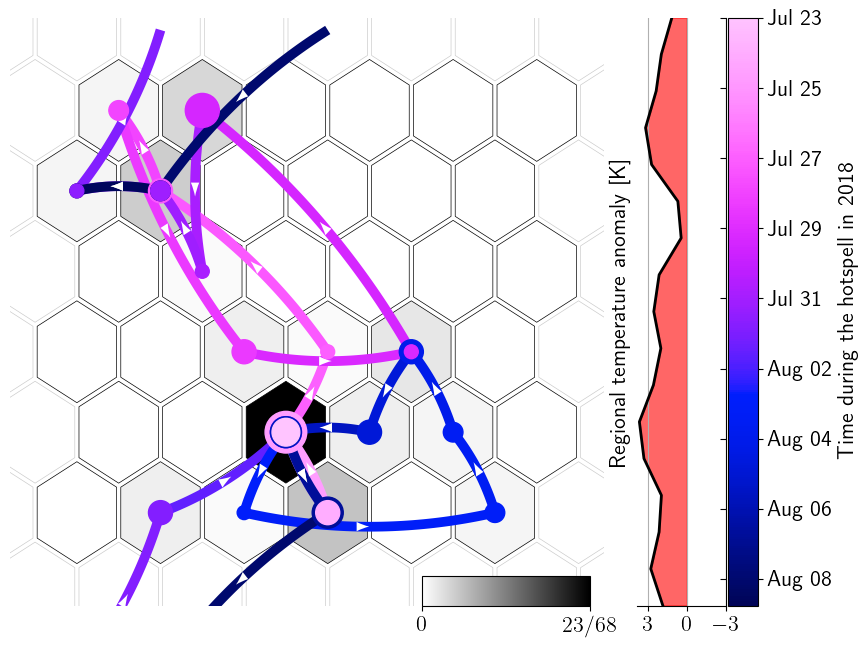

In [ ]:
hotspells, _, _ = get_hotspells_v2(lag_behind=0)
region = 1
n_hotspell = 241
hotspell = hotspells[region][n_hotspell]

fig, ax, cbar, traj, segments, arcs = plt_traj_hotspell(hotspell, net.bmus, 0, 0, da_T, get_region_mask(region))
fig.savefig(f'{FIGURES}/som_props/hotspell_2018.png', dpi=300, bbox_inches='tight')

In [ ]:
midpoints = 0.5 * (segments[:, 0, :] + segments[:, 1, :])
tangents  = 0.5 * (segments[:, 1, :] - segments[:, 0, :])
norm_tangents = np.linalg.norm(tangents, axis=-1)
r = norm_tangents * 5
tangents_perp = tangents[:, [1, 0]] * np.asarray([[1, -1]])
centers = midpoints - np.sqrt(r[:, None] ** 2 / norm_tangents[:, None] ** 2 - 1) * tangents_perp
correction = segments[:, :, 0] - centers[:, None, 0] < 0
correction = np.pi * correction.astype(float)
endpoints = np.arctan((segments[:, :, 1] - centers[:, None, 1]) / (segments[:, :, 0] - centers[:, None, 0])) - correction
ts = (endpoints[:, 0, None] + (endpoints[:, 1, None] - endpoints[:, 0, None]) * np.linspace(0, 1, 50)[None, :])
arcs = centers[:, None, :] + np.asarray([r[:, None] * np.cos(ts), r[:, None] * np.sin(ts)]).transpose(1, 2, 0)

In [ ]:
np.where(np.diff(segments[:, :, 1], axis=1) == 0)

(array([ 6, 10, 15, 19, 23]), array([0, 0, 0, 0, 0]))

## Skew and Kurtosis of bmu histogram during hotspell

In [ ]:
n_max = max([max([len(hotspell) for hotspell in hotspells_]) for hotspells_ in hotspells])
n_min = 4

def agnostic_distribution(traj: NDArray | xr.DataArray):
    uniques, counts = np.unique(traj, return_counts=True)
    sortby = np.argsort(counts)[::-1]
    return uniques[sortby], counts[sortby]

def random_sample_kurtosis(n_days: int):
    year = np.random.choice(YEARSPL_EXT)
    year_mask = DATERANGEPL_EXT_6H_SUMMER.year == year
    start_from = np.random.randint(np.sum(year_mask) - n_days * 4)
    idx_range = np.argmax(year_mask) + start_from + np.arange(n_days * 4)
    take_from = net.bmus[idx_range]
    _, counts = agnostic_distribution(take_from)
    return counts, skew(counts), kurtosis(counts), np.mean(np.diff(take_from) != 0)

n_draws = 100
skews, kurtosises, speeds = np.zeros((n_max - n_min + 1, n_draws)), np.zeros((n_max - n_min + 1, n_draws)), np.zeros((n_max - n_min + 1, n_draws))
counts = np.zeros((n_max - n_min + 1, n_draws, n_max + 1))
for i_n, n in enumerate(range(n_min, n_max + 1)):
    for draw in range(n_draws):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            these_counts, skews[i_n, draw], kurtosises[i_n, draw], speeds[i_n, draw] = random_sample_kurtosis(n)
        counts[i_n, draw, :len(these_counts)] = these_counts

In [ ]:
from itertools import zip_longest

hotspell_counts = []
hotspell_skews = []
hotspell_kurtosises = []
hotspell_mean_temp = []
hotspell_speeds = []
for ir, hotspells_ in enumerate(hotspells):
    hotspell_counts.append([])
    hotspell_skews.append([])
    hotspell_kurtosises.append([])
    hotspell_mean_temp.append([])
    hotspell_speeds.append([])
    region_mask = get_region_mask(ir)
    for hotspell in hotspells_:
        if len(hotspell) < n_min:
            continue
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            traj_da, traj = get_traj(hotspell, net.bmus)
            _, hs_counts = agnostic_distribution(traj)
            hotspell_counts[-1].append(hs_counts.tolist())
            hotspell_skews[-1].append(skew(hotspell_counts[-1][-1]))
            hotspell_kurtosises[-1].append(kurtosis(hotspell_counts[-1][-1]))
            hotspell_mean_temp[-1].append(da_T.loc[traj_da.time].where(region_mask).mean(dim=['lon', 'lat', 'time']).item())
            hotspell_speeds[-1].append(np.mean(np.diff(traj) != 0))
hotspell_counts_loa = [np.stack(list(zip_longest(*hotspell_counts_, fillvalue=np.nan))).T for hotspell_counts_ in hotspell_counts]

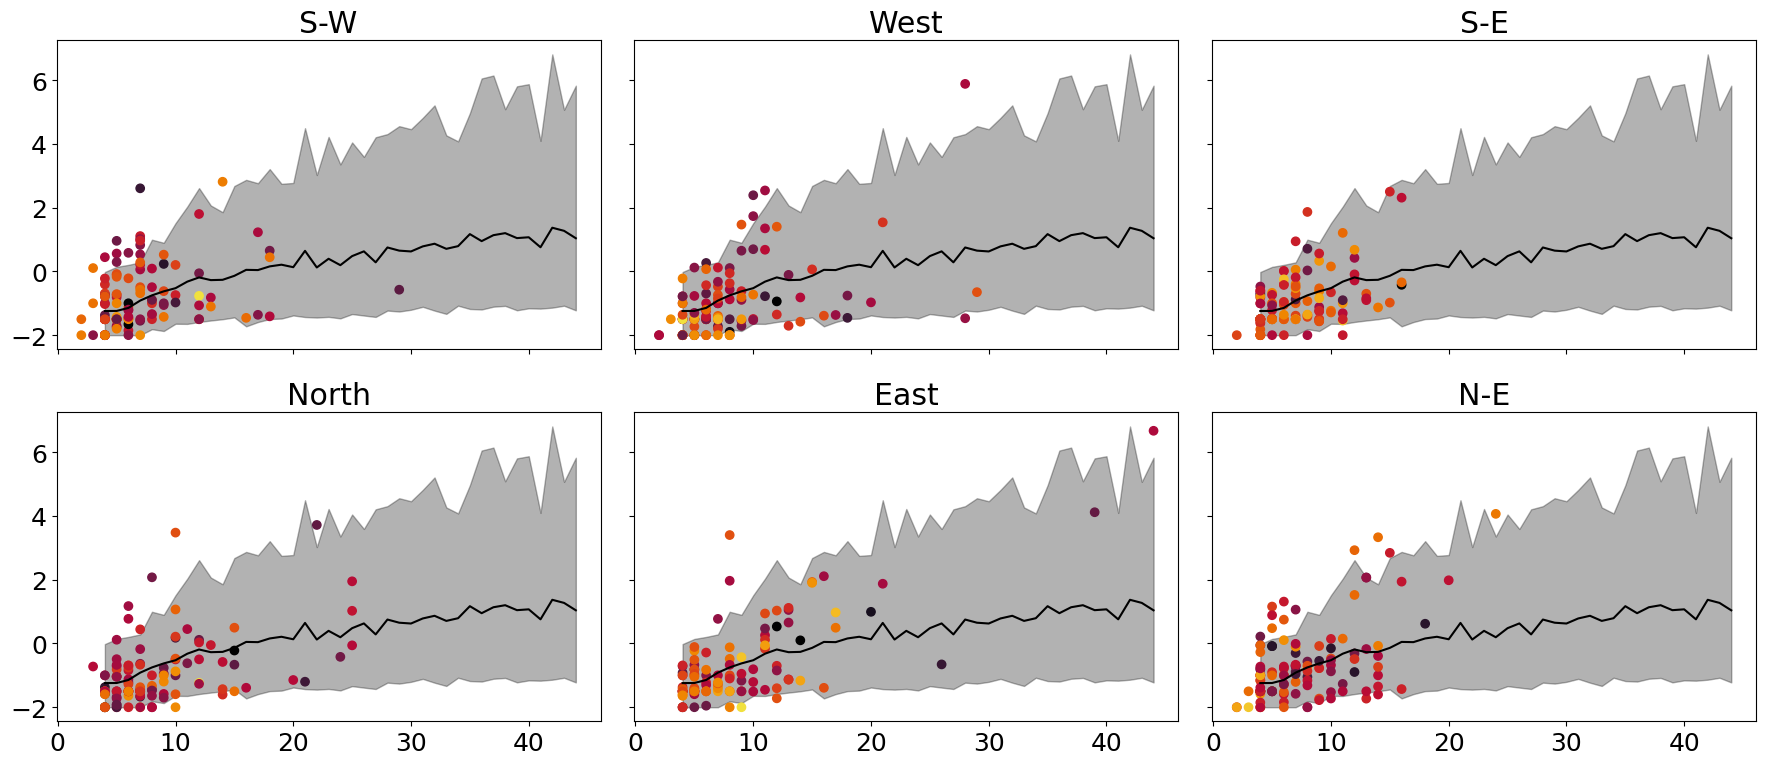

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), tight_layout=True, sharex=True, sharey=True)
for ir, (region, ax) in enumerate(zip(REGIONS, axes.ravel())):
    ax.plot(np.arange(kurtosises.shape[0]) + n_min, np.nanmean(kurtosises, axis=1), color='black')
    ax.fill_between(np.arange(kurtosises.shape[0]) + n_min, *np.nanquantile(kurtosises, axis=1, q=[0.05, 0.95]), alpha=0.3, color='black')
    lens = np.nansum(hotspell_counts_loa[ir], axis=1)
    ax.scatter(lens / 4, hotspell_kurtosises[ir], label=region, cmap=colormaps.ember, c=hotspell_mean_temp[ir])
    ax.set_title(region)

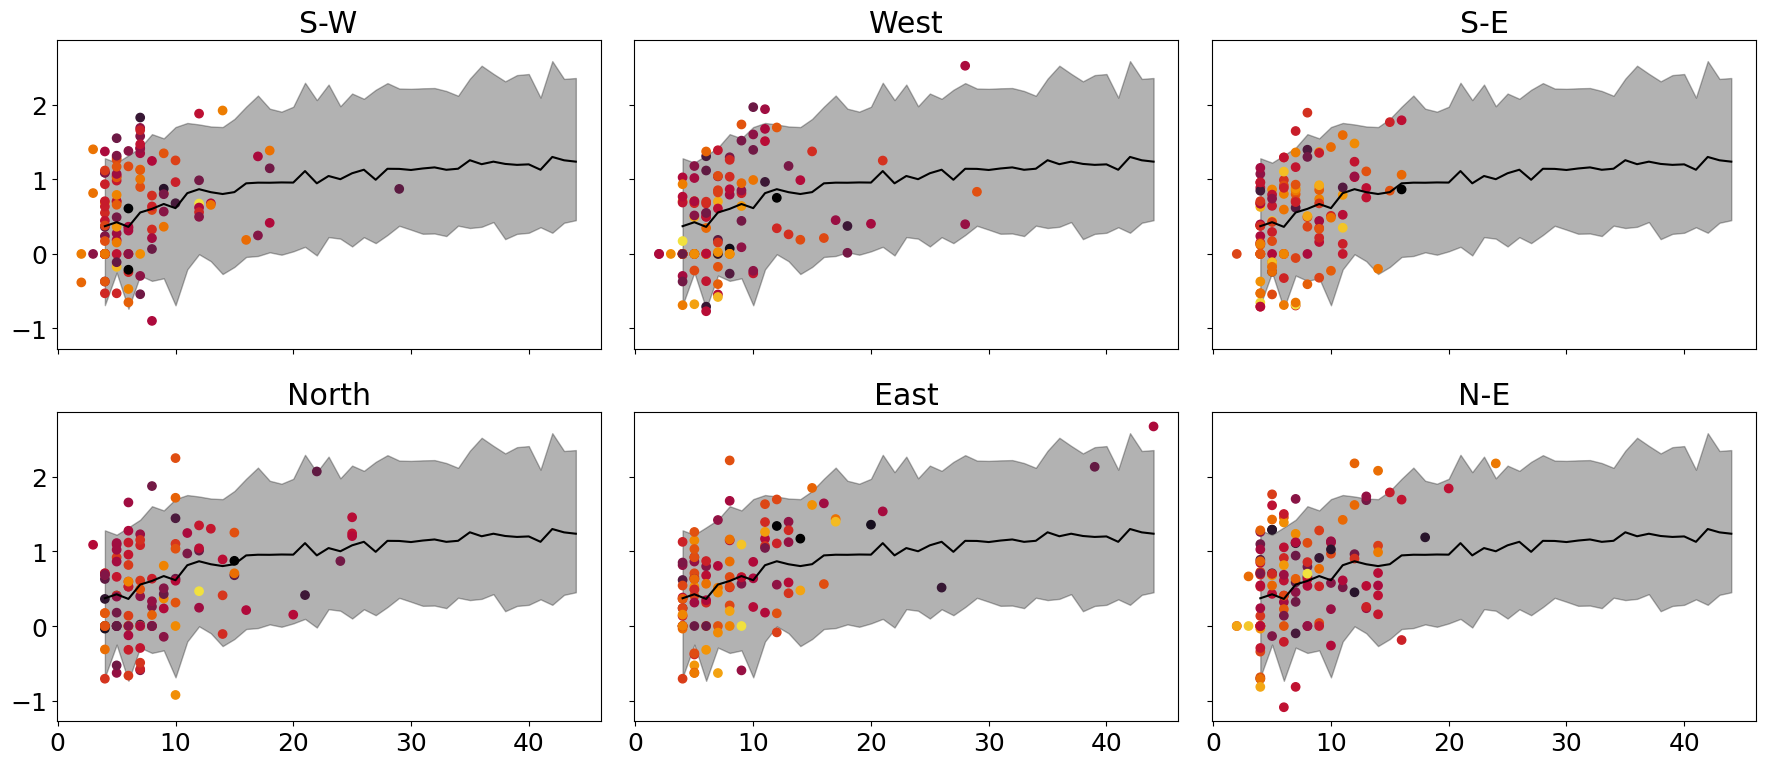

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), tight_layout=True, sharex=True, sharey=True)
for ir, (region, ax) in enumerate(zip(REGIONS, axes.ravel())):
    ax.plot(np.arange(skews.shape[0]) + n_min, np.nanmean(skews, axis=1), color='black')
    ax.fill_between(np.arange(skews.shape[0]) + n_min, *np.nanquantile(skews, axis=1, q=[0.05, 0.95]), alpha=0.3, color='black')
    lens = np.nansum(hotspell_counts_loa[ir], axis=1)
    ax.scatter(lens / 4, hotspell_skews[ir], label=region, cmap=colormaps.ember, c=hotspell_mean_temp[ir])
    ax.set_title(region)

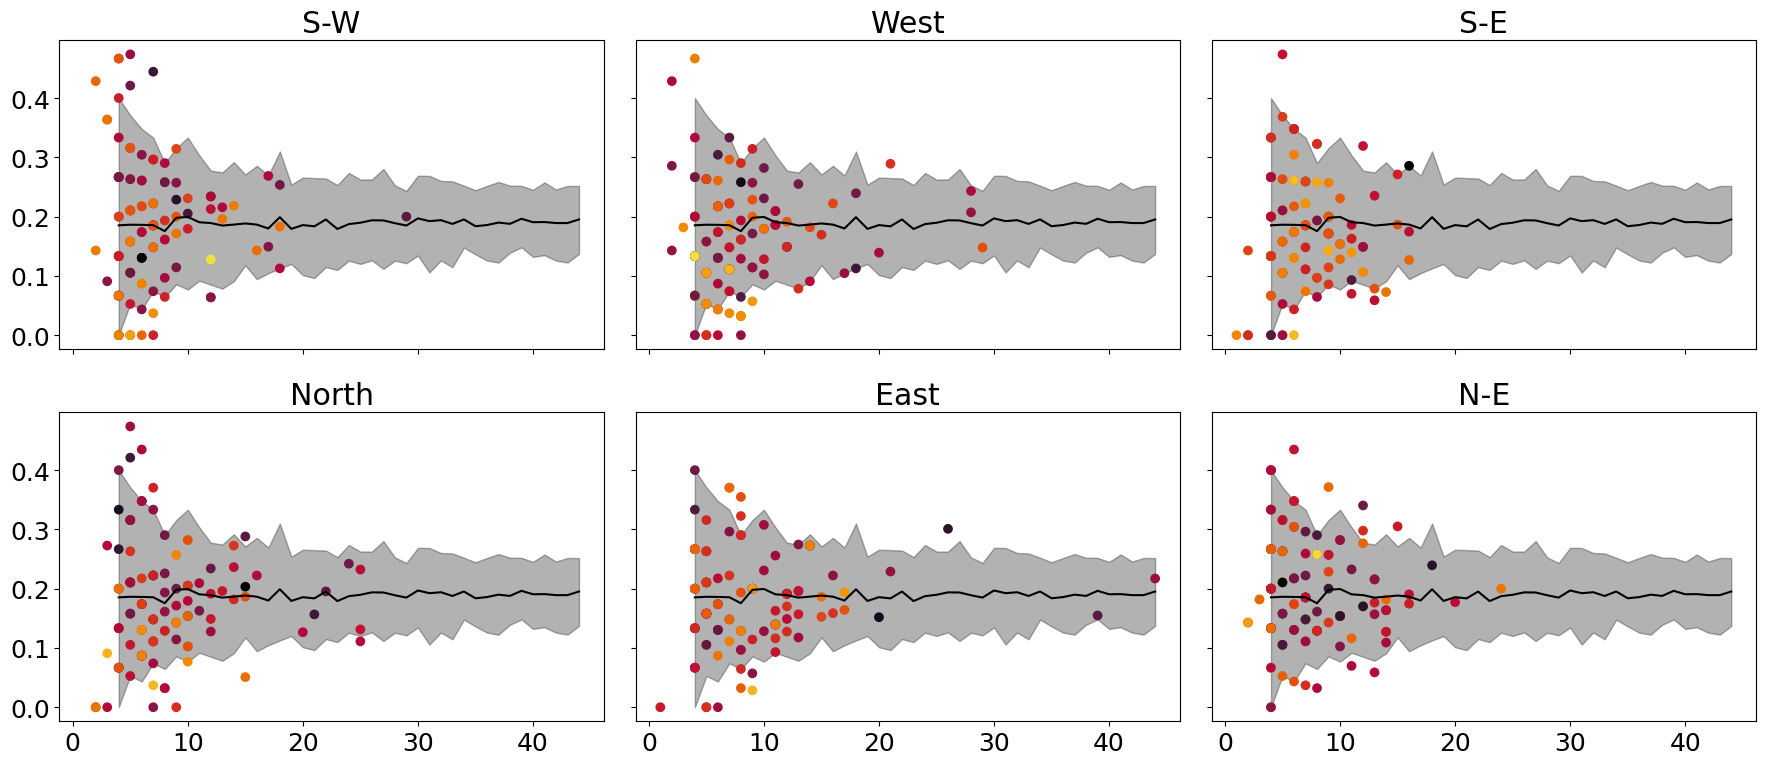

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8), tight_layout=True, sharex=True, sharey=True)
for ir, (region, ax) in enumerate(zip(REGIONS, axes.ravel())):
    ax.plot(np.arange(speeds.shape[0]) + n_min, np.nanmean(speeds, axis=1), color='black')
    ax.fill_between(np.arange(speeds.shape[0]) + n_min, *np.nanquantile(speeds, axis=1, q=[0.05, 0.95]), alpha=0.3, color='black')
    lens = np.nansum(hotspell_counts_loa[ir], axis=1)
    ax.scatter(lens / 4, hotspell_speeds[ir], label=region, cmap=colormaps.ember, c=hotspell_mean_temp[ir])
    ax.set_title(region)

## Whole period, attribution and conditional probas

In [ ]:
num_lags = 3 * 4
hotspells = get_hotspells_v2(lag_behind=num_lags)[0]
clustered_hotspells = {region: [[] for _ in range(net.n_nodes)] for region in REGIONS}
unattributed = {region: [] for region in REGIONS}
for k, region in enumerate(REGIONS):
    for j, hotspell in enumerate(hotspells[k]):
        try:
            unique, counts = np.unique(labels.loc[hotspell[:2 * num_lags]], return_counts=True)
            remove_zero = unique != 0
            unique = unique[remove_zero] - 1
            counts = counts[remove_zero]
            where = np.argmax(counts)
            clustered_hotspells[region][int(unique[where])].append((len(hotspell), j))
        except KeyError:
            unattributed[region].append((len(hotspell), j))
            

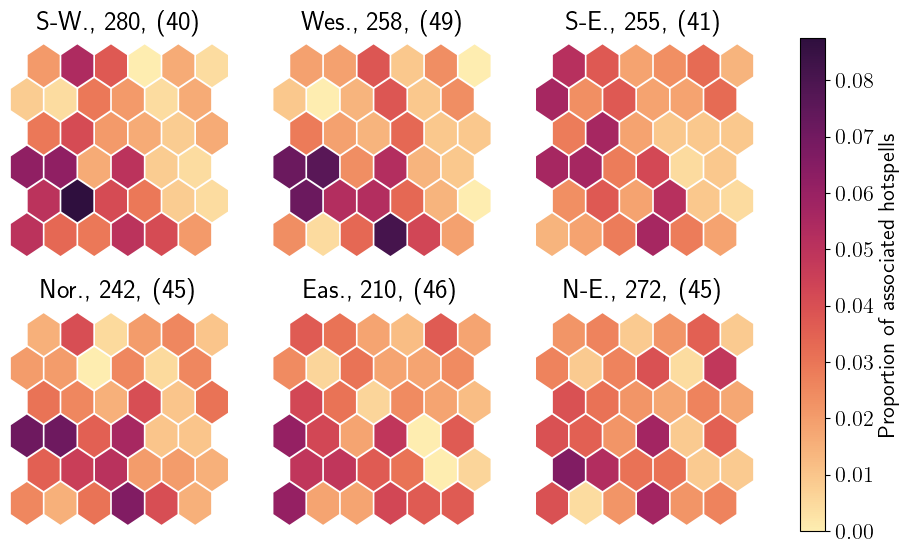

In [ ]:

to_plot = np.asarray([[len(cluhs) for cluhs in list_of_nodes] for list_of_nodes in clustered_hotspells.values()])
denominator = np.asarray([len(hs) for hs in hotspells]) - np.asarray([len(unat) for unat in unattributed.values()])
to_plot = to_plot / denominator[:, None]
kwargs = {
    "cmap": colormaps.matter,
    "norm": Normalize(0, np.amax(to_plot))
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for k, (region, tplt) in enumerate(zip(REGIONS, to_plot)):
    ax = axes[k]
    fig, ax = net.plot_on_map(
        tplt,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        **kwargs,
    )
    ax.set_title(f"{region[:3]}., {len(hotspells[k])}, ({len(unattributed[region])})")
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label="Proportion of associated hotspells")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')


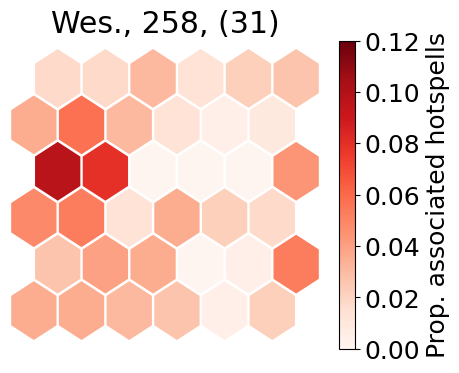

In [ ]:
kwargs = {
    "cmap": "Reds",
    "norm": Normalize(0, 0.12),
}
fig, ax = plt.subplots(figsize=(5, 4))
region = "West"
k = 1
list_of_nodes = clustered_hotspells[region]
tplt = np.asarray([len(l) for l in list_of_nodes])
fig, ax = net.plot_on_map(
    tplt / (len(hotspells[k]) - len(unattributed[region])),
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=ax,
    draw_cbar=False,
    **kwargs,
)
ax.set_title(f"{region[:3]}., {len(hotspells[k])}, ({len(unattributed[region])})")
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=ax, label="Prop. associated hotspells")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')


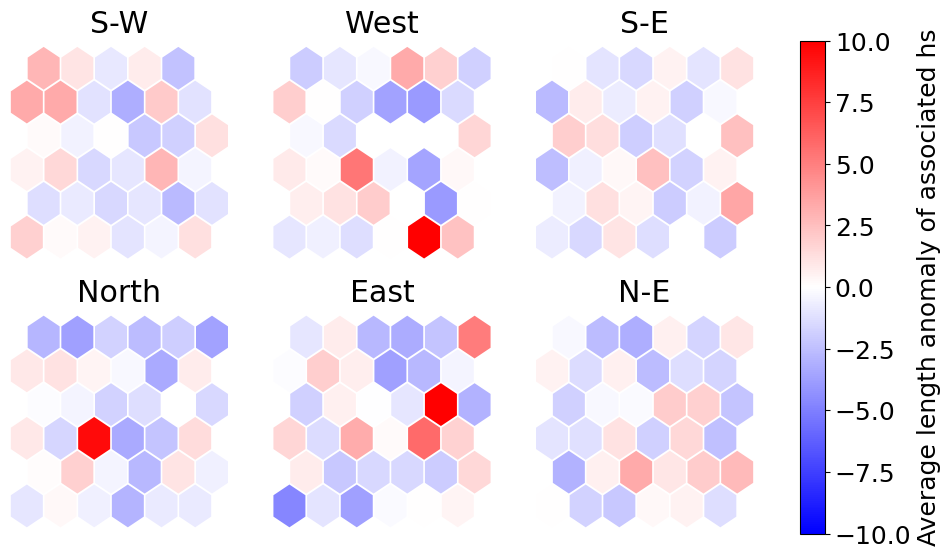

In [ ]:
kwargs = {
    "cmap": "bwr",
    "norm": Normalize(-10, 10),
}
fig, axes = plt.subplots(2, 3, figsize=(12, 8 * 0.8))
axes = axes.ravel()
for k, (region, list_of_nodes) in enumerate(clustered_hotspells.items()):
    ax = axes[k]
    tplt = [np.mean([hs_info[0] for hs_info in l]) for l in list_of_nodes]
    fig, ax = net.plot_on_map(
        tplt - np.nanmean([len(l) for l in hotspells[k]]),
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        **kwargs
    )
    ax.set_title(region)
im = ScalarMappable(**kwargs)
fig.colorbar(im, ax=axes, label="Average length anomaly of associated hs")
# plt.savefig('Figures/som_abs_cluster_hotspells.svg')
